
# Import packages


In [ ]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from datetime import date
from pvlib.iotools import read_epw

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging

import pickle

In [2]:
dir = 'C:\\GitHub\\microclimate-dl-predict\\'

measurenames={"RH0719":'RH',"Tem0719":'Temperature'}
measureunit={"Tem0719":'°C',"RH0719":'%'}

measures = ["RH0719","Tem0719"]
measure = measures[0]
testmeasures = ["RH0819","Tem0819"]
testmeasure = testmeasures[0]


# Load, verify and process input files

In [5]:
datadir=dir+'data\\'
df = pd.read_csv(datadir + measure +'.csv')
testdf = pd.read_csv(datadir + testmeasure +'.csv')

# df = df.drop(df.index[2])

amy,meta=read_epw(datadir+'SGP_Singapore.486980_IWEC.epw')
changi,meta=read_epw(datadir+'SGP_SINGAPORE-CHANGI-AP_486980S_19.epw')
measurekey={"Tem0719":'temp_air',"RH0719":'relative_humidity'}

mykey=measurekey[measure]
changidata=changi.loc[(changi['year'].astype('str')+changi['month'].astype('str')=='20197'),[mykey]]
amydata=amy.loc[(amy['month'].astype('str')=='7'),[mykey]]
windspeeddf = pd.read_csv(datadir + 'ws0719.csv')
solardf = pd.read_csv(datadir + 'sr0719.csv')

In [ ]:
griddf = pd.read_csv(datadir + '1m_GridPoints_distTo_and_zones_3414.csv').fillna(0)
wsdf = pd.read_csv(datadir + 'WSPoints_TreesAndStreets_3414.csv').fillna(0)

t = pd.concat([griddf, pd.get_dummies(griddf.HorticultureZone)], axis=1)
t = t.replace("Temparea", 1)
t = t.replace("Vegetated Ridge", 1)
# t = t.replace("Valley", 1)
# t = t.rename(columns={"Area": "VegetatedRidge"})
### drop features that share high correlation with other features (not useful for prediction)
griddf = t.drop(['id','HorticultureZone'], axis=1)
# griddf = t.drop(['id','HorticultureZone','gridarea','buildingfootprintarea','roadarea','patharea','walkwayarea','courttrackarea','carparkarea'], axis=1)
### set points within VegetatedRidge to have distToTree 0.0 (trees within the area are not doccumented but the area is densely forrested)
### helps a bit to make distToTree useful but numtrees is still inaccurate for this area
griddf['distToTree'].loc[griddf['VegetatedRidge'] == 1] = 0.0

t = pd.concat([wsdf, pd.get_dummies(wsdf.HorticultureZone)], axis=1)
t = t.replace("Temparea", 1)
t = t.replace("Vegetated Ridge", 1)
t = t.replace("Valley", 1)
# t = t.rename(columns={"Area": "VegetatedRidge"})
t = t.sort_values(by=['ID'])
### drop features that share high correlation with other features (not useful for prediction)
wsdf = t.drop(['Lat','Long','HorticultureZone','Location','Type','Description','gridarea','buildingfootprintarea','roadarea','patharea','walkwayarea','courttrackarea','carparkarea'], axis=1)
wsdf = wsdf.reset_index(drop=True)

plotdf = testdf.transpose().iloc[2:16,:]
plotdf['X']=list(wsdf['X'])
plotdf['Y']=list(wsdf['Y'])

display(wsdf)
display(griddf.head())

In [ ]:
### Plot scatterplot of each feature against average Tmax (weather station data, using Mar-19)
fig, axs = plt.subplots(4, 6, figsize = (18, 9))

for i in range(4):
    for j in range(6):
        k = i * 6 + j
        if k >= len(wsdf.columns):
            break
        
        axs[i][j].scatter(wsdf[wsdf.columns[k]], df.iloc[2:16,3])
        axs[i][j].set_title(wsdf.columns[k])

fig.tight_layout()
plt.show()

<Axes: >

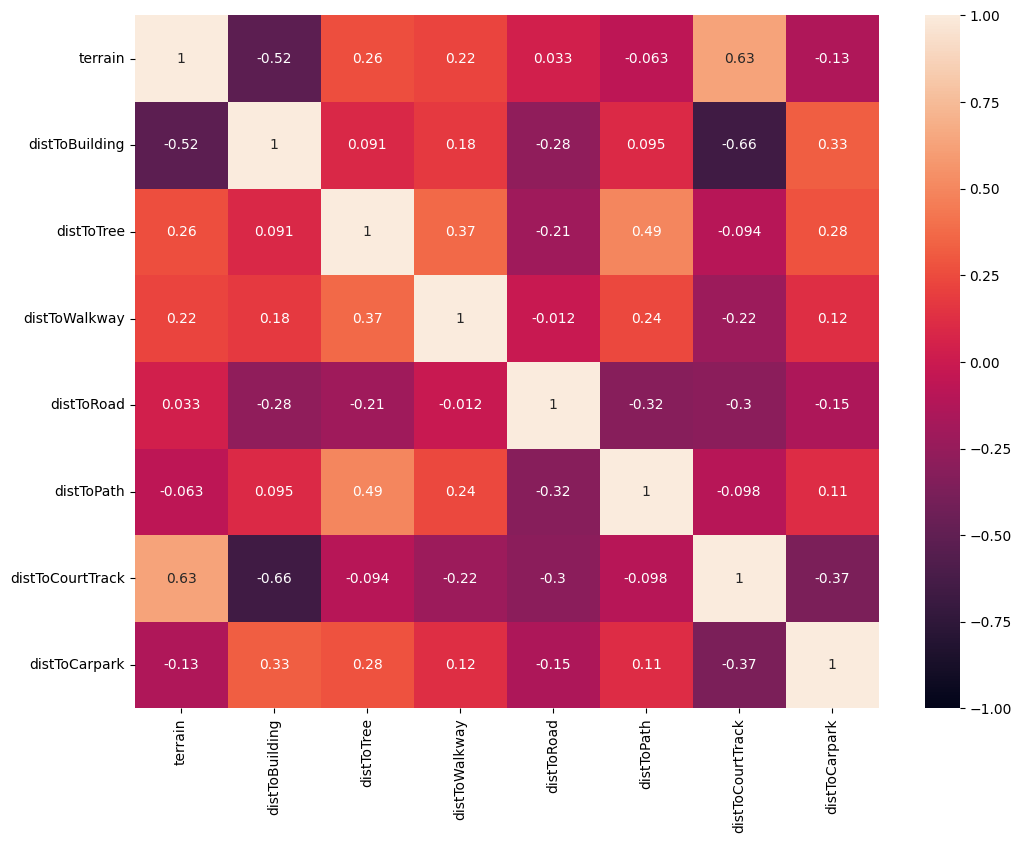

In [8]:
### Plot feature correlations
percentfeatures=['percentroad','percentpath','percentwalkway','percentcourttrack','percentcarpark']
features = ['terrain','distToBuilding','distToTree','distToWalkway','distToRoad','distToPath','distToCourtTrack','distToCarpark']
f,ax = plt.subplots(figsize = (12, 9))
sns.heatmap(wsdf.corr().loc[features,features],vmin = -1,annot = True, ax = ax)
#plt.title('Correlation matrix of LULC features', size=35)

# Models construction

In [12]:
import torch.nn as nn
from torch.autograd import Variable

percentfeatures=['percentroad','percentpath','percentwalkway','percentcourttrack','percentcarpark']
    
class geolayer(nn.Module):
    def __init__(self):
        super(geolayer,self).__init__()
        



class MyModel(nn.Module):
    def __init__(self, embedding_length, hidden_size,output_size,batch_size):
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        super(MyModel, self).__init__()
        self.lstm = nn.LSTM(embedding_length, hidden_size,batch_first=True)
        self.label = nn.Linear(hidden_size, output_size)
    def forward(self, input):
        h_0 = Variable(torch.zeros(1,self.batch_size, self.hidden_size))
        c_0 = Variable(torch.zeros(1,self.batch_size, self.hidden_size))
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
        return self.label(final_hidden_state[-1]) 
class gru(nn.Module):
    def __init__(self, embedding_length, hidden_size,output_size,batch_size):
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        super(gru, self).__init__()
        self.lstm = nn.GRU(embedding_length, hidden_size,batch_first=True)
        self.label = nn.Linear(hidden_size, output_size)
    def forward(self, input):
        h_0 = Variable(torch.zeros(1,self.batch_size, self.hidden_size))
        
        output, final_hidden_state = self.lstm(input, h_0)
        return self.label(final_hidden_state[-1]) 


def train_model(model, train_iter, epoch):
    model.train()
    for e in range(epoch):
        loss=0
        optimizer.zero_grad()
        for idx, batch in enumerate(train_iter):
            prediction = model(batch.x)
            loss = loss + torch.norm(prediction-batch.y,"fro")
        loss=loss/(idx+1)
        print("epoch {}: Training Loss normalized Root MSE : {} %".format(e,np.sqrt(loss.detach().numpy())) )
        loss.backward()
        optimizer.step()
        if loss <0.1:
            break
    return loss

class Mydata():
    def __init__(self,x,y):
        self.x=x
        self.y=y

methods=['_lstmrk_','_lstmok_','_grurk_','_gruok_','_ne_','_iwec_','_changi_']#'
data=[]
testdata=[]
if batchsize ==1:
    for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
        data.append(Mydata(torch.tensor((np.delete(hourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(hourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
    for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
        testdata.append(Mydata(torch.tensor((np.delete(testhourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(testhourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

else:
    for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
        data.append(Mydata(torch.tensor(np.array([(np.delete(hourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                    ,torch.tensor((np.delete(hourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
    for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
        testdata.append(Mydata(torch.tensor(np.array([(np.delete(testhourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                    ,torch.tensor((np.delete(testhourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

puredata={}
for method in methods:
    puredata[measure+method]=plotdf.iloc[:,embedding_length:embedding_length+len(data)*batchsize].to_numpy()


# Weather data process

In [ ]:
embedding_length=15
batchsize=16
#mymodel=gru(embedding_length=embedding_length,hidden_size=64,output_size=13,batch_size=batchsize)
#optimizer = torch.optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
npdata=np.array(pd.read_csv(datadir + measure +'.csv').iloc[:,2:16])
hourdata=np.sum(npdata.reshape([-1,60,14]),axis=1)/60
testhourdata=np.sum(np.array(testdf.iloc[:,2:16]).reshape([-1,60,14]),axis=1)/60
mean = hourdata.mean()
std = hourdata.std()
pdhourdata=pd.DataFrame(hourdata).transpose()
pdhourdata['X']=list(wsdf['X'])
pdhourdata['Y']=list(wsdf['Y'])


# Station clustering according to the prediction error

In [85]:

errormatrix=np.array(puredata['Tem0719_lstmrk_'])
errormatrix=errormatrix[:,8:-16]
tmperror=errormatrix.reshape(-1,24)
tmperror[61,:]-errormatrix[2,24:48]

from sklearn.cluster import KMeans
nclu=4
kmeans = KMeans(n_clusters=nclu, random_state=0, n_init="auto").fit(tmperror)
tmpclusterresult=kmeans.labels_.reshape(14,-1)
clusterresult=np.zeros((14,nclu))
for i in range(14):
    for j in range(nclu):   
        clusterresult[i,j]=np.sum(tmpclusterresult[i,:]==j)

clusterresult=clusterresult/tmpclusterresult.shape[1]
wsdf['cluster']=list(clusterresult)

# Visualize the clustering result

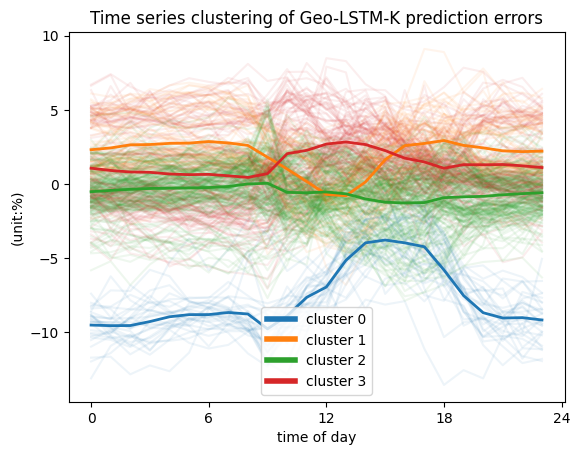

In [384]:

tmparray=np.array(puredata['RH0719_lstmrk_'])[:,8:-16].reshape(-1,24)
colors=sns.color_palette()
fig,ax=plt.subplots()
for i in range(tmparray.shape[0]):
    sns.lineplot(tmparray[i,:],color=colors[kmeans.labels_[i]],alpha=0.08,ax=ax)
for j in range(nclu):
    sns.lineplot(tmparray[kmeans.labels_==j,:].mean(axis=0),color=colors[j],linewidth=2,ax=ax)
ax.set_xticks([0,6,12,18,24])
ax.set_xlabel('time of day')
ax.set_ylabel('(unit:%)')
ax.set_title('Time series clustering of Geo-LSTM-K prediction errors')
ax.legend(custom_lines, ['cluster 0', 'cluster 1', 'cluster 2','cluster 3'])

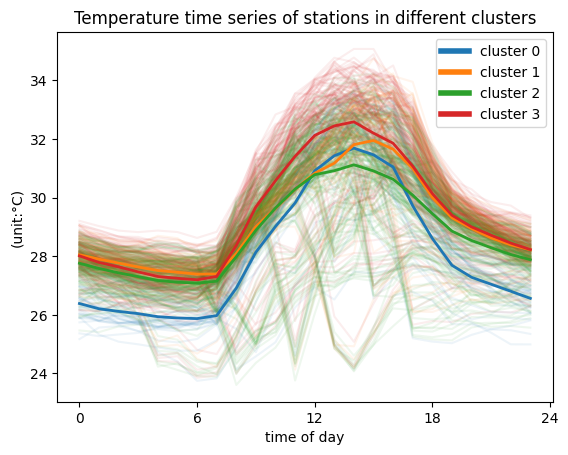

In [335]:
measure='Tem0719'
df = pd.read_csv(datadir + measure +'.csv')
tmparray=np.mean(np.array(df.drop(columns=['Date','Time']).loc[1440:43199,:]).reshape(-1,60,14),axis=1).transpose().reshape(-1,24)
colors=sns.color_palette()
fig,ax=plt.subplots()
for i in range(tmparray.shape[0]):
    sns.lineplot(tmparray[i,:],color=colors[kmeans.labels_[i]],alpha=0.08)
for j in range(nclu):
    sns.lineplot(tmparray[kmeans.labels_==j,:].mean(axis=0),color=colors[j],linewidth=2)
ax.set_xticks([0,6,12,18,24])
ax.set_xlabel('time of day')
ax.set_ylabel('(unit:{})'.format(measureunit[measure]))
ax.set_title('{} time series of stations in different clusters'.format(measurenames[measure]))
ax.legend(custom_lines, ['cluster 0', 'cluster 1', 'cluster 2','cluster 3'])


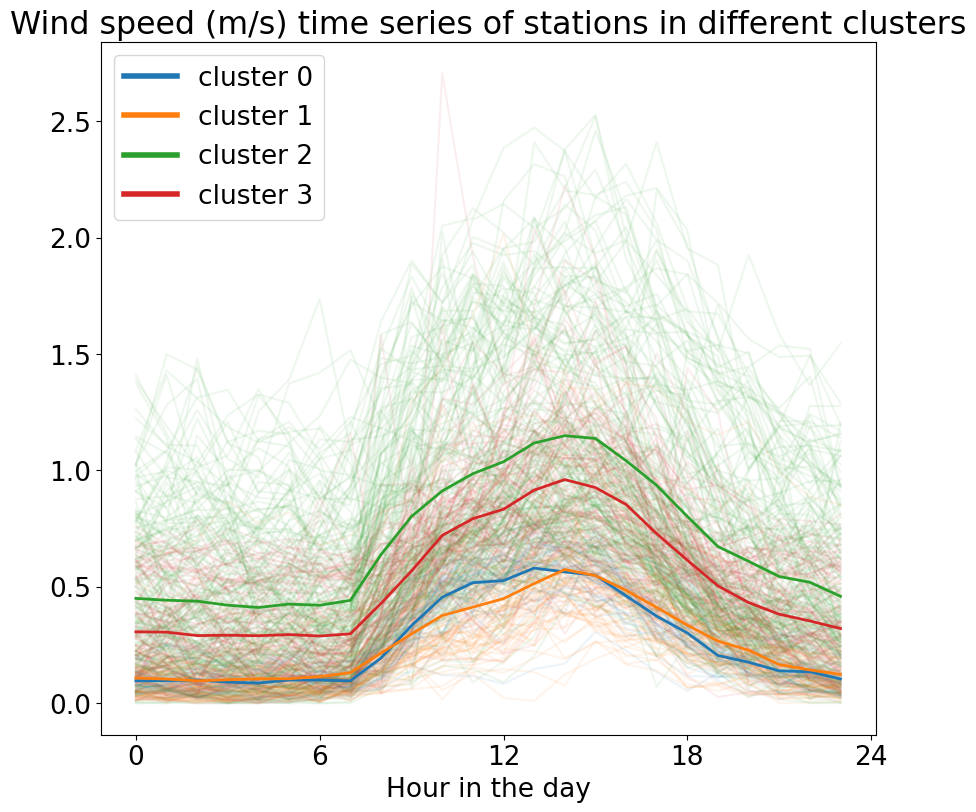

In [699]:
tmparray=np.mean(np.array(windspeeddf.drop(columns=['Date','Time']).loc[1440:43199,:]).reshape(-1,60,14),axis=1).transpose().reshape(-1,24)
colors=sns.color_palette()
fig,ax=plt.subplots(figsize=(10,9))
for i in range(tmparray.shape[0]):
    sns.lineplot(tmparray[i,:],color=colors[kmeans.labels_[i]],alpha=0.08)
for j in range(nclu):
    sns.lineplot(tmparray[kmeans.labels_==j,:].mean(axis=0),color=colors[j],linewidth=2)
ax.set_xticks([0,6,12,18,24])
ax.set_xlabel('Hour in the day')
#ax.set_ylabel('(unit:')
ax.set_title('Wind speed (m/s) time series of stations in different clusters')
ax.legend(custom_lines, ['cluster 0', 'cluster 1', 'cluster 2','cluster 3'])


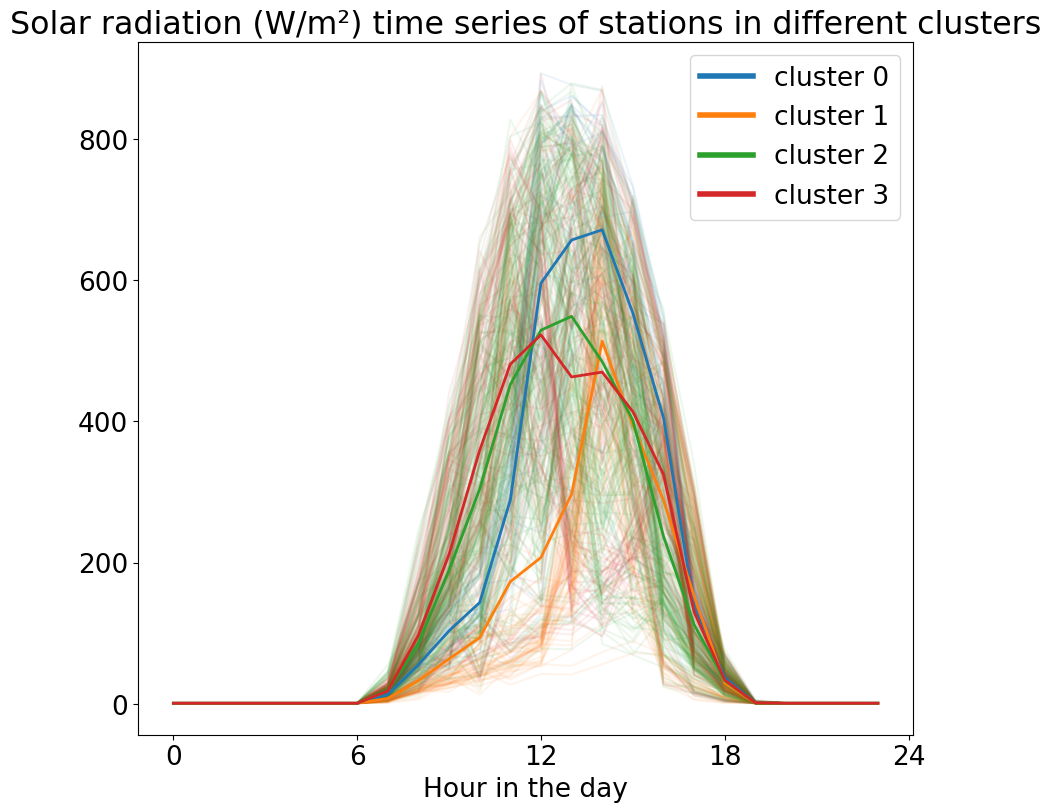

In [698]:
tmparray=np.mean(np.array(solardf.drop(columns=['Date','Time']).loc[1440:43199,:]).reshape(-1,60,14),axis=1).transpose().reshape(-1,24)
colors=sns.color_palette()
fig,ax=plt.subplots(figsize=(10,9))
for i in range(tmparray.shape[0]):
    sns.lineplot(tmparray[i,:],color=colors[kmeans.labels_[i]],alpha=0.08)
for j in range(nclu):
    sns.lineplot(tmparray[kmeans.labels_==j,:].mean(axis=0),color=colors[j],linewidth=2)
ax.set_xticks([0,6,12,18,24])
ax.set_xlabel('Hour in the day')
#ax.set_ylabel('(unit:')
ax.set_title('Solar radiation (W/m²) time series of stations in different clusters')
ax.legend(custom_lines, ['cluster 0', 'cluster 1', 'cluster 2','cluster 3'])


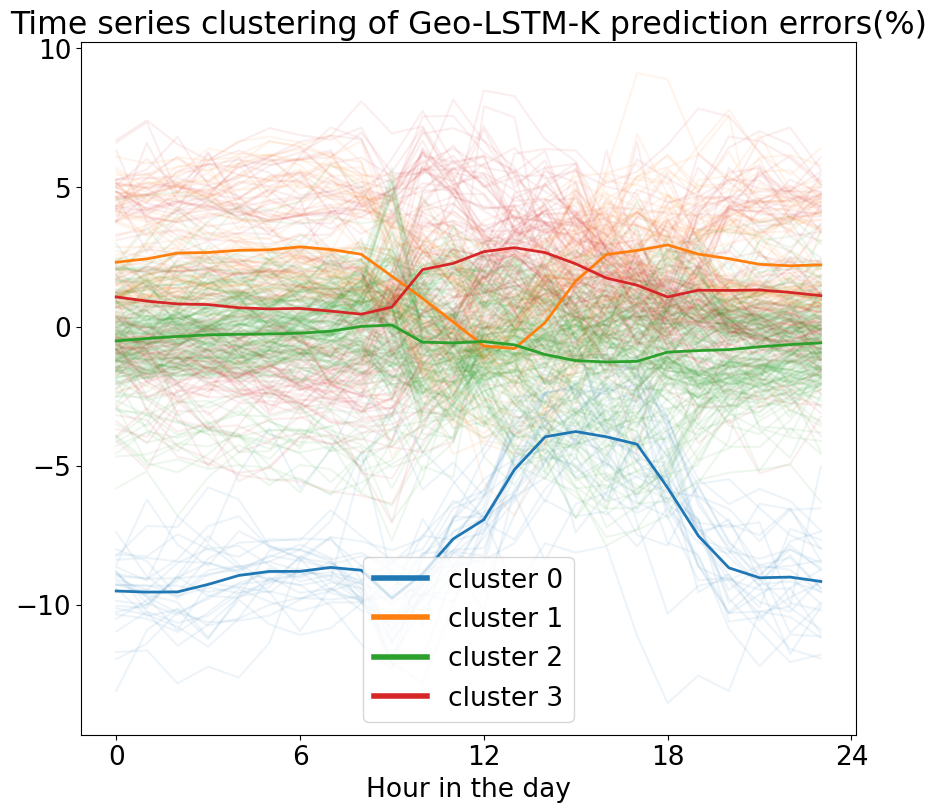

In [701]:
colors=sns.color_palette()
fig,ax=plt.subplots(figsize=(10,9))
measure='RH0719'
errormatrix=np.array(puredata[measure+'_lstmrk_'])
errormatrix=errormatrix[:,8:-16]
tmperror=errormatrix.reshape(-1,24)
for i in range(tmperror.shape[0]):
    sns.lineplot(tmperror[i,:],color=colors[kmeans.labels_[i]],alpha=0.08)
for j in range(nclu):
    sns.lineplot(tmperror[kmeans.labels_==j,:].mean(axis=0),color=colors[j],linewidth=2)
ax.set_xticks([0,6,12,18,24])
ax.set_xlabel('Hour in the day')
#ax.set_ylabel('(unit:°C)')
ax.set_title('Time series clustering of Geo-LSTM-K prediction errors({})'.format(measureunit[measure]))
ax.legend(custom_lines, ['cluster 0', 'cluster 1', 'cluster 2','cluster 3'])

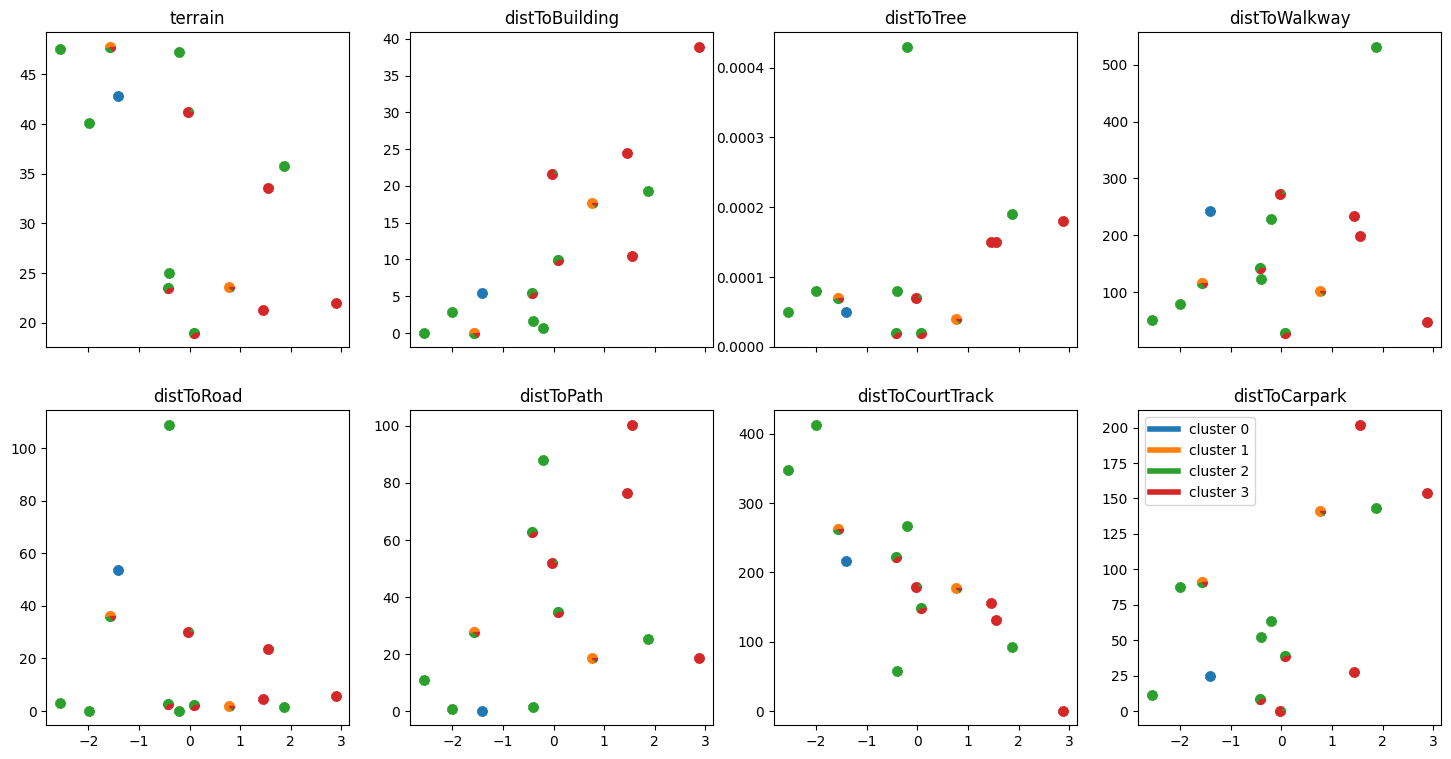

In [719]:
def drawPieMarker(xs, ys, ratios, sizes, colors,ax):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        if ratio==0:
            continue
        else:
            markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker)

plt.rcParams.update({'font.size': 10})  
fig, axs = plt.subplots(2, 4, figsize = (18, 9),sharex=True,sharey=False)

colors=sns.color_palette()
for j in range(8):
    for i in range(14):
        drawPieMarker(xs=PCA(n_components=1).fit_transform(errormatrix)[i],
                    ys=wsdf.loc[i,features[j]],
                    ratios=clusterresult[i,:],
                    sizes=[50],
                    colors=colors[0:4],
                    ax=axs[int(np.floor(j/4))][int(np.mod(j,4))])
    axs[int(np.floor(j/4))][int(np.mod(j,4))].set_title(features[j])
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color, lw=4) for color in colors]
axs[-1][-1].legend(custom_lines, ['cluster 0', 'cluster 1', 'cluster 2','cluster 3'])
plt.show()

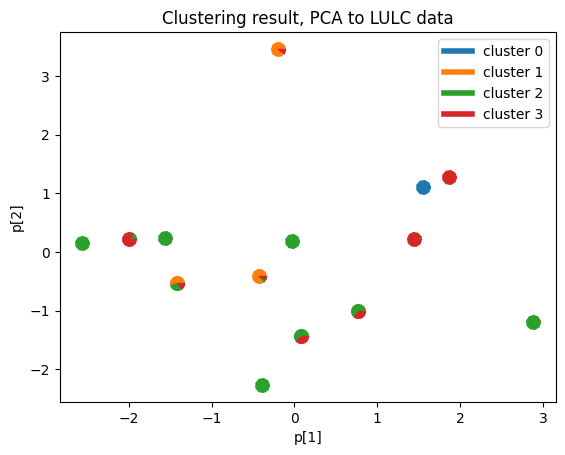

In [455]:
import numpy as np
import matplotlib.pyplot as plt

def drawPieMarker(xs, ys, ratios, sizes, colors):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        if ratio != 0:
            markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker)


fig, ax = plt.subplots()
for i in range(14):
    drawPieMarker(xs=pcaxy[i,0],#xs=wsdf.loc[i,'X'],
                ys=pcaxy[i,1],#ys=wsdf.loc[i,'Y'],
                ratios=clusterresult[i,:],
                sizes=[100],
                colors=colors[0:4])
ax.legend(custom_lines, ['cluster 0', 'cluster 1', 'cluster 2','cluster 3'])
ax.set_xlabel('p[1]')
ax.set_ylabel('p[2]')
plt.title('Clustering result, PCA to LULC data')
plt.show()

In [ ]:
#heatmap
## Select features for model, excluded most of the percent** because they seem quite small and not significant, especially for features with small area like walkways
#puredata save the prediction errors, the two naive prediction method is computed ahead.
for i, mth in enumerate(range(len(data))):
    truevalue = hourdata[mth*batchsize+embedding_length:(mth+1)*batchsize+embedding_length,:]
    puredata[measure+'_iwec_'][:,mth*batchsize:(mth+1)*batchsize] = (amydata.iloc[mth*batchsize+embedding_length:(mth+1)*batchsize+embedding_length].to_numpy()-truevalue).transpose()
    puredata[measure+'_changi_'][:,mth*batchsize:(mth+1)*batchsize] = (changidata.iloc[mth*batchsize+embedding_length:(mth+1)*batchsize+embedding_length].to_numpy()-truevalue).transpose()

features = ['terrain','distToBuilding','distToTree','distToWalkway','distToRoad','distToPath','distToCourtTrack','distToCarpark']
p = wsdf[features].drop(targetstationid)
target_p = griddf[features]
target_x = np.array(list(zip(griddf.X, griddf.Y)))

feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

nth = [5,12,31]
batchindex = 5

data=[]
testdata=[]
allstations=np.array(range(14))
targetstationid=7
otherstationsid=np.delete(allstations,targetstationid).tolist()
with open('trainednw\\{}lstmmodel_target{}.pkl'.format(measure,targetstationid), 'rb') as f:
        mymodel = pickle.load(f)
if batchsize ==1:
    for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
        data.append(Mydata(torch.tensor((np.delete(hourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(hourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
    for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
        testdata.append(Mydata(torch.tensor((np.delete(testhourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(testhourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

else:
    for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
        data.append(Mydata(torch.tensor(np.array([(np.delete(hourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                    ,torch.tensor((np.delete(hourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
    for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
        testdata.append(Mydata(torch.tensor(np.array([(np.delete(testhourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                    ,torch.tensor((np.delete(testhourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))


for k in variogram_models:
    print(k)
    # model = SVR(C=C, gamma=gamma, kernel=k)
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    # model = LinearRegression(copy_X=True, fit_intercept=False)

    scores_mths = []
    #train_model(mymodel, data, epoch=1000)
    griddflist=[]
    for i, mth in enumerate(nth):
        griddflist.append(griddf.copy())
        print("Date : {}, Time : {}".format(df.iloc[(mth*batchsize+batchindex+embedding_length)*60,0],df.iloc[(mth*batchsize+batchindex+embedding_length)*60,1]))

        x = np.array(list(zip(wsdf.drop(targetstationid).X, wsdf.drop(targetstationid).Y)))
        truevalue = hourdata[mth*batchsize+batchindex+embedding_length,:]
        lastdayvalue = hourdata[mth*batchsize+batchindex+embedding_length-24,:]
        target = mymodel(data[mth].x)[batchindex,:].detach().numpy()*std+mean
        # p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
        #     p, x, target, test_size=0.3, random_state=42
        # )
        plotdf['plotdata'+str()]=truevalue
        print("=" * 40)
        m_ok = OrdinaryKriging(x[:,0],x[:,1],target,variogram_model=k,verbose=False)
        m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

        # m_rk.fit(p_train, x_train,target_train)
        # score = m_rk.score(p_test, x_test,target_test)
        # scores_mths.append(score)

        m_rk.fit(p, x, target)
        result = m_rk.predict(target_p, target_x)
        griddflist[i][measure+'_lstmrk_'] = result
    fig, axes = plt.subplots(3, 1, figsize=(10, 16), sharex=True)
    for timeidx,ax in enumerate(axes):
        hue_norm=(round(min(griddflist[timeidx][measure+'_lstmrk_']),1),round(max(griddflist[timeidx][measure+'_lstmrk_']),1))
        g = sns.scatterplot(x="X", y="Y",
                        hue=measure+'_lstmrk_',
                        palette="Spectral_r",
                        data=griddflist[timeidx],
                        hue_norm=hue_norm,
                        edgecolor="none",
                        ax=ax)
        sns.scatterplot(x="X", y="Y",
                        hue='plotdata'+[timeidx],
                        palette="Spectral_r",
                        data=plotdf.iloc[otherstationsid],
                        hue_norm=hue_norm,
                        edgecolor="black",
                        legend=None,
                        ax=ax)
        sns.scatterplot(x="X", y="Y",
                        hue='plotdata',
                        palette="Spectral_r",
                        data=plotdf.iloc[[targetstationid]],
                        hue_norm=hue_norm,
                        edgecolor="white",
                        legend=None,
                        ax=ax)
        ax.set_title("Temperature prediction samples, Date : {}, Time : {}".format(df.iloc[(mth*batchsize+batchindex+embedding_length)*60,0],df.iloc[(mth*batchsize+batchindex+embedding_length)*60,1]))
        
        # plt.savefig(dir + 'Export/' + measure + mth + '.png', bbox_inches='tight')
        plt.show()
        griddflist[timeidx].to_csv(dir + 'Export/' + measure + str(mth) + '.csv')
        
    ### Only for RandomForestRegressor, to extract feature importances
    feature_importance_df[mth] = m_rk.regression_model.feature_importances_
    featuredf = pd.DataFrame(list(zip(m_rk.regression_model.feature_names_in_, m_rk.regression_model.feature_importances_)), columns =['FeatureName', 'FeatureImportance'])
    display(featuredf.sort_values(by=['FeatureImportance'], ascending=False))

        ### Add properties to geojson and export
        # Tmaxes = resultdf['Tmax'].tolist()
        # for i in range(len(resultdf.index)):
        #     basejson['features'][i]['properties']['Tmax'] = Tmaxes[i]
        # with open(dir + 'Export/' + measure + mth + '.geojson', 'w') as outfile:
        #     json.dump(basejson, outfile)

    # avg = sum(scores_mths) / len(scores_mths)
    # scores_all.append([k,C,gamma,n] + scores_mths + [avg] )

# Sample of prediction

In [40]:
#measure='Tem0719'
measure='RH0719'
npdata=np.array(pd.read_csv(dir + measure +'.csv').iloc[:,2:16])
hourdata=np.sum(npdata.reshape([-1,60,14]),axis=1)/60
testhourdata=np.sum(np.array(testdf.iloc[:,2:16]).reshape([-1,60,14]),axis=1)/60
mean = hourdata.mean()
std = hourdata.std()

data=[]
testdata=[]
allstations=np.array(range(14))
targetstationid=7
otherstationsid=np.delete(allstations,targetstationid).tolist()
with open('trainednw\\{}lstmmodel_target{}.pkl'.format(measure,targetstationid), 'rb') as f:
        mymodel = pickle.load(f)
if batchsize ==1:
    for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
        data.append(Mydata(torch.tensor((np.delete(hourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(hourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
    for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
        testdata.append(Mydata(torch.tensor((np.delete(testhourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(testhourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

else:
    for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
        data.append(Mydata(torch.tensor(np.array([(np.delete(hourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                    ,torch.tensor((np.delete(hourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
    for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
        testdata.append(Mydata(torch.tensor(np.array([(np.delete(testhourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                    ,torch.tensor((np.delete(testhourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

griddflist=[]
plotdflist=[]
for i, mth in enumerate(months):
    griddflist.append(griddf.copy())
    plotdflist.append(plotdf.copy())
    print("Date : {}, Time : {}".format(df.iloc[(mth*batchsize+batchindex+embedding_length)*60,0],df.iloc[(mth*batchsize+batchindex+embedding_length)*60,1]))

    x = np.array(list(zip(wsdf.drop(targetstationid).X, wsdf.drop(targetstationid).Y)))
    truevalue = hourdata[mth*batchsize+batchindex+embedding_length,:]
    lastdayvalue = hourdata[mth*batchsize+batchindex+embedding_length-24,:]
    target = mymodel(data[mth].x)[batchindex,:].detach().numpy()*std+mean
    # p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
    #     p, x, target, test_size=0.3, random_state=42
    # )
    plotdf['plotdata']=truevalue
    print("=" * 40)
    m_ok = OrdinaryKriging(x[:,0],x[:,1],target,variogram_model=k,verbose=False)
    m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

    # m_rk.fit(p_train, x_train,target_train)
    # score = m_rk.score(p_test, x_test,target_test)
    # scores_mths.append(score)

    m_rk.fit(p, x, target)
    result = m_rk.predict(target_p, target_x)
    griddflist[i][measure+'_lstmrk_'] = result

Date : 05/07/19, Time : 04:00:00
Finished learning regression model
Finished kriging residuals
Date : 09/07/19, Time : 20:00:00
Finished learning regression model
Finished kriging residuals
Date : 22/07/19, Time : 12:00:00
Finished learning regression model
Finished kriging residuals


# Print the prediction results

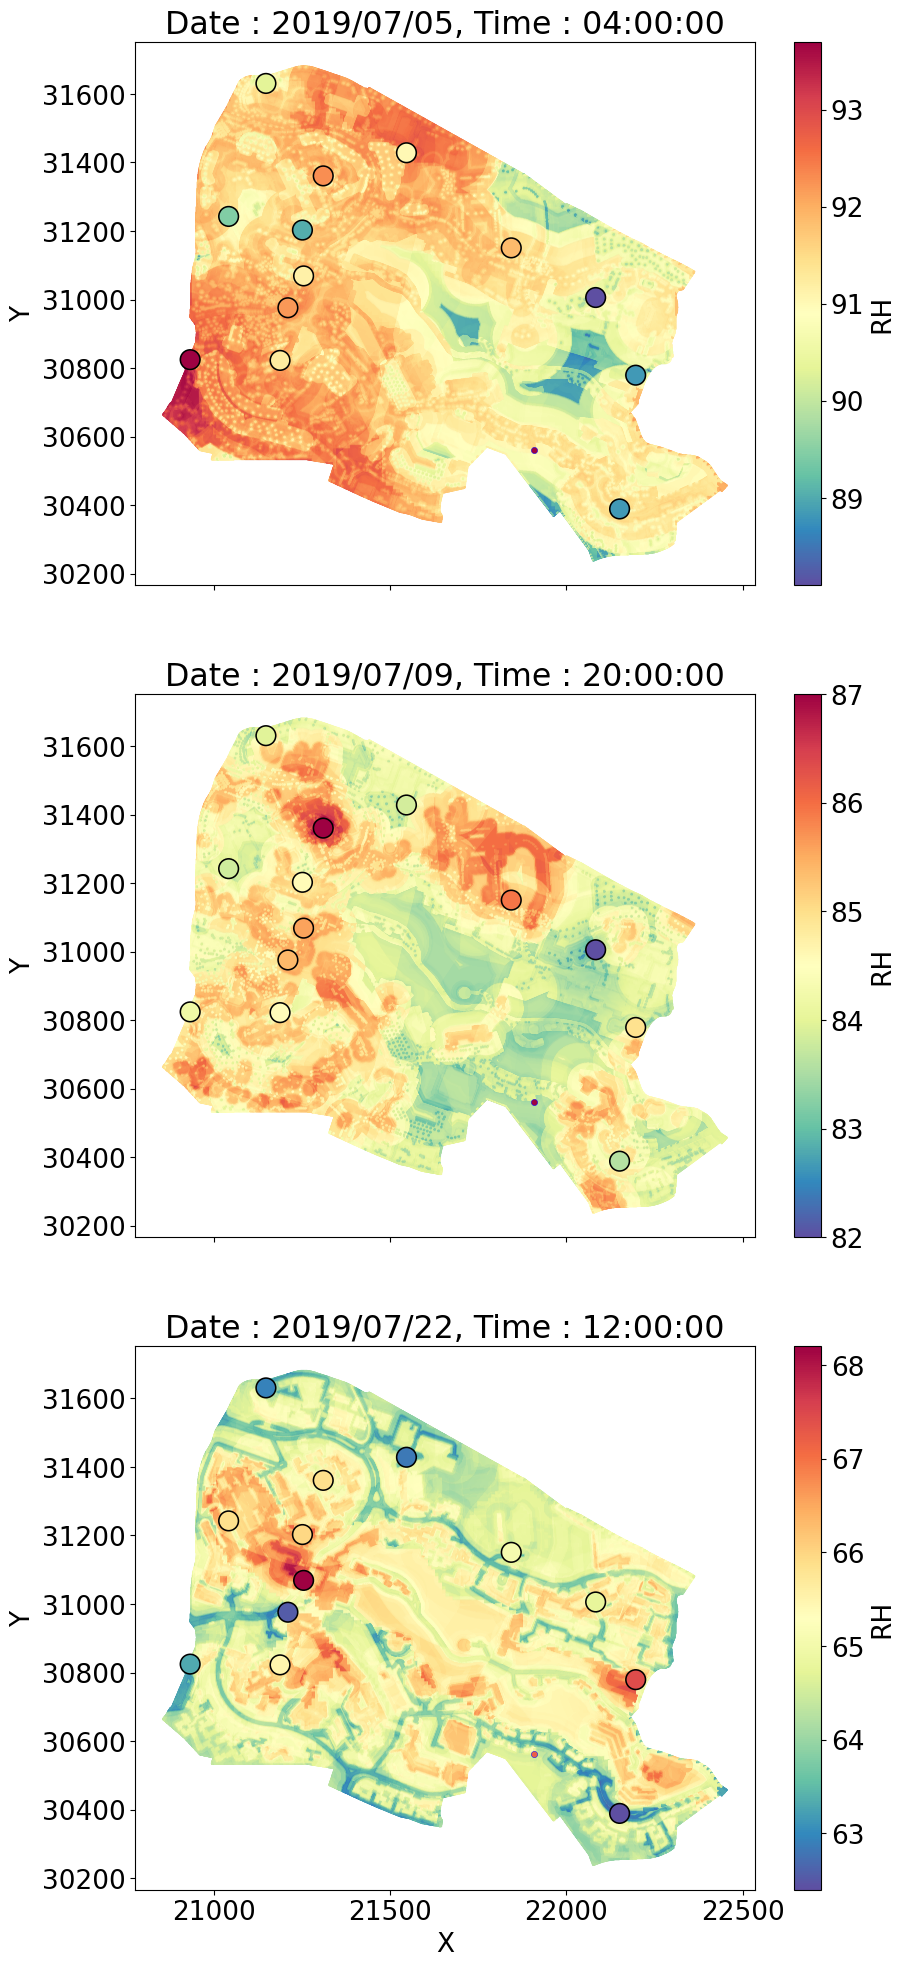

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(10, 24), sharex=True)
plt.rcParams.update({'font.size': 19})
import matplotlib as mpl
#cmap=sns.cubehelix_palette(as_cmap=True)
pdhourdata=pd.DataFrame(hourdata).transpose()
pdhourdata['X']=list(wsdf['X'])
pdhourdata['Y']=list(wsdf['Y'])
for timeidx,ax in enumerate(axes):
    hue_norm=(round(min(griddflist[timeidx][measure+'_lstmrk_']),1),round(max(griddflist[timeidx][measure+'_lstmrk_']),1))
    g = sns.scatterplot(x="X", y="Y",s=2,
                    hue=measure+'_lstmrk_',
                    palette=sns.color_palette("Spectral_r",as_cmap=True),
                    data=griddflist[timeidx],
                    hue_norm=hue_norm,
                    edgecolor="none",
                    legend=None,
                    ax=ax)
    cmap = sns.color_palette("Spectral_r",as_cmap=True)
    norm = mpl.colors.Normalize(vmin=hue_norm[0], vmax=hue_norm[1])

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label=measurenames[measure])
    #fig.colorbar(sns.mappable(sns.color_palette("Spectral_r",as_cmap=True)),ax=g)
    sns.scatterplot(x="X", y="Y",  s=200,
                    hue=(months[timeidx]*batchsize+batchindex+embedding_length),
                    palette=sns.color_palette("Spectral_r",as_cmap=True),
                    data=pdhourdata.iloc[otherstationsid],
                    hue_norm=hue_norm,
                    edgecolor="black",
                    legend=None,
                    ax=ax)
    sns.scatterplot(x="X", y="Y", s=20,
                    hue=(months[timeidx]*batchsize+batchindex+embedding_length),
                    palette=sns.color_palette("Spectral_r",as_cmap=True),
                    data=pdhourdata.iloc[[targetstationid]],
                    hue_norm=hue_norm,
                    edgecolor="blue",
                    legend=None,
                    ax=ax)
    ax.set_title("Date : {}, Time : {}".format('20'+df.iloc[(months[timeidx]*batchsize+batchindex+embedding_length)*60,0][6:8]+df.iloc[(months[timeidx]*batchsize+batchindex+embedding_length)*60,0][2:6]+df.iloc[(months[timeidx]*batchsize+batchindex+embedding_length)*60,0][0:2],df.iloc[(months[timeidx]*batchsize+batchindex+embedding_length)*60,1]))
    
    # plt.savefig(dir + 'Export/' + measure + mth + '.png', bbox_inches='tight')
plt.show()

# Comparison with baselines

In [ ]:
#not changed yet
## Select features for model, excluded most of the percent** because they seem quite small and not significant, especially for features with small area like walkways
features = ['terrain','distToBuilding','distToTree','distToWalkway','distToRoad','distToPath','distToCourtTrack','distToCarpark']
p = wsdf[features].drop(targetstationid)
target_p = wsdf.loc[targetstationid,features].to_numpy().reshape(1,-1)
target_x = np.array([(wsdf.loc[targetstationid,'X'],wsdf.loc[targetstationid,'Y'])]).reshape(1,-1)

feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

#months = ["Feb-19","Mar-19","Apr-19","May-19","Jun-19","Jul-19","Aug-19","Sep-19","Oct-19","Nov-19","Dec-19","Jan-20","Feb-20","Mar-20","Apr-20"]
months = [12,31,5]
#months = [21]
batchindex = 5
### Load base geojson grid to export geojson file
basejson = []
# with open(dir + 'GeoJSON/BaseGrid.geojson', 'r') as file:
#     basejson = json.load(file)
dt=[]
for i, mth in enumerate(months):
    dt.append("Date : {}, Time : {}".format(df.iloc[(mth*batchsize+batchindex+embedding_length)*60,0],df.iloc[(mth*batchsize+batchindex+embedding_length)*60,1]))
    plotdf[measure+'_rk_'+dt[i]]=0
    plotdf[measure+'_ok_'+dt[i]]=0
    plotdf[measure+'_ne_'+dt[i]]=0
for targetstationid in range(14):    
    allstations=np.array(range(14))
    otherstationsid=np.delete(allstations,targetstationid).tolist()
    import pickle
    data=[]
    testdata=[]
    if batchsize ==1:
        for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
            data.append(Mydata(torch.tensor((np.delete(hourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(hourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
        for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
            testdata.append(Mydata(torch.tensor((np.delete(testhourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(testhourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

    else:
        for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
            data.append(Mydata(torch.tensor(np.array([(np.delete(hourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                        ,torch.tensor((np.delete(hourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
        for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
            testdata.append(Mydata(torch.tensor(np.array([(np.delete(testhourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                        ,torch.tensor((np.delete(testhourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

    with open('TEMmodel_target{}.pkl'.format(targetstationid), 'rb') as f:
        mymodel = pickle.load(f)
    #mymodel=MyModel(embedding_length=embedding_length,hidden_size=64,output_size=13,batch_size=batchsize)
    train_model(mymodel, data, epoch=1000)
    with open('TEMmodel_target{}.pkl'.format(targetstationid),'wb') as f:
        pickle.dump(mymodel,f)
    #mymodel=clf2
    

    for k in variogram_models:
        # print(k)
        # model = SVR(C=C, gamma=gamma, kernel=k)
        model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
        # model = LinearRegression(copy_X=True, fit_intercept=False)

        scores_mths = []
        #
        #   continue
        
        for i, mth in enumerate(months):
            
            x = np.array(list(zip(wsdf.drop(targetstationid).X, wsdf.drop(targetstationid).Y)))
            truevalue = hourdata[mth*batchsize+batchindex+embedding_length,:]
            target = mymodel(data[mth].x)[batchindex,:].detach().numpy()*std+mean
            # p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
            #     p, x, target, test_size=0.3, random_state=42
            # )
            print("=" * 40)
            m_ok = OrdinaryKriging(x[:,0],x[:,1],target,variogram_model=k,verbose=False)
            m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

            # m_rk.fit(p_train, x_train,target_train)
            # score = m_rk.score(p_test, x_test,target_test)
            # scores_mths.append(score)

            m_rk.fit(p, x, target)
            result = m_rk.predict(target_p, target_x)
            plotdf.loc[:,measure+'_rk_'+dt[i]].iloc[[targetstationid]] = result[0]-truevalue[targetstationid]
            z,sigma=m_ok.execute('points',target_x[0,0],target_x[0,1])
            plotdf.loc[:,measure+'_ok_'+dt[i]].iloc[[targetstationid]] = z[0]-truevalue[targetstationid]
            plotdf.loc[:,measure+'_ne_'+dt[i]].iloc[[targetstationid]] = truevalue[otherstationsid[np.argmin((wsdf.loc[otherstationsid,'X']-wsdf.loc[targetstationid,'X'])**2+(wsdf.loc[otherstationsid,'Y']-wsdf.loc[targetstationid,'Y'])**2)]]-truevalue[targetstationid]
            
for i, mth in enumerate(months):
    print(dt[i])        
    for method in methods:
        g = sns.scatterplot(x="X", y="Y",
                        hue=measure+method+dt[i],
                        palette="Spectral_r",
                        data=plotdf.iloc[otherstationsid,:],
                        #hue_norm=(-1,1),
                        edgecolor="black")
        plt.title("Temperature prediction error samples, Date : {}, Time : {}".format(df.iloc[(mth*batchsize+batchindex+embedding_length)*60,0],df.iloc[(mth*batchsize+batchindex+embedding_length)*60,1]))
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # plt.savefig(dir + 'Export/' + measure + mth + '.png', bbox_inches='tight')
        #resultdf.to_csv(dir + 'Export/' + measure + mth + '.csv')
    error=result-truevalue
    display(error)

        ### Add properties to geojson and export
        # Tmaxes = resultdf['Tmax'].tolist()
        # for i in range(len(resultdf.index)):
        #     basejson['features'][i]['properties']['Tmax'] = Tmaxes[i]
        # with open(dir + 'Export/' + measure + mth + '.geojson', 'w') as outfile:
        #     json.dump(basejson, outfile)

    # avg = sum(scores_mths) / len(scores_mths)
    # scores_all.append([k,C,gamma,n] + scores_mths + [avg] )


fig, axes = plt.subplots(clusternum, 1, figsize=(10, 16), sharex=True)
for clusterid,ax in enumerate(axes):
    sns.boxplot(data = puredata[plotdf['cluster']==clusterid].to_numpy().reshape(-1,24), ax=ax) 
    ax.set_ylabel("") 
    ax.set_title("Temperature prediction error of stations in cluster {}".format(clusterid)) 
    if ax != axes[-1]: 
        ax.set_xlabel('')
    else:
        ax.set_xlabel("time in the day")
        

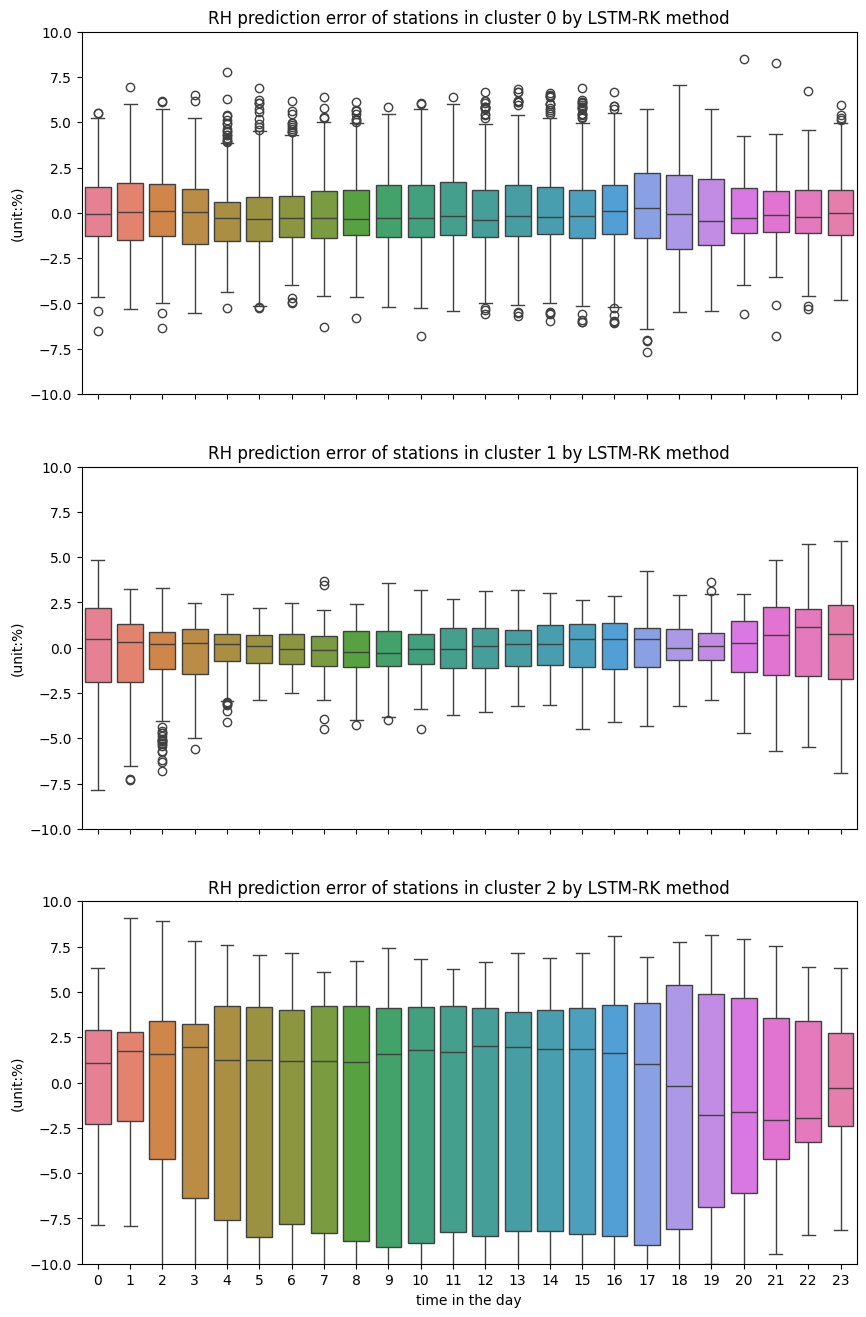

In [533]:
fig, axes = plt.subplots(3, 1, figsize=(10, 16), sharex=True)
#for i, (method,ax) in enumerate(zip(methods,axes)):
for clusterid,ax in enumerate(axes):
    #sns.boxplot(data = puredata[method].reshape(-1,24), ax=ax) 
    sns.boxplot(data = puredata[measure+'_lstmrk_'][plotdf['cluster']==clusterid].reshape(-1,24), ax=ax) 
    ax.set_ylim([-10,10])
    ax.set_ylabel("(unit:%)") 
    ax.set_title("RH prediction error of stations in cluster {} by LSTM-RK method".format(clusterid)) 
    if ax != axes[-1]: 
        ax.set_xlabel('')
    else:
        ax.set_xlabel("time in the day")

In [107]:
plottempdf=None
for i, method in enumerate(methods):
    tempdf=pd.DataFrame(data=np.array(puredata[measure+method]).reshape(-1,1))
    tempdf['method']=methodnames[i]
    tempdf['time']=list(range(24))*420
    if plottempdf is None:
        plottempdf=tempdf.copy()
    else:
        plottempdf=pd.concat([plottempdf,tempdf])

Text(0.5, 0, 'Hour in the day')

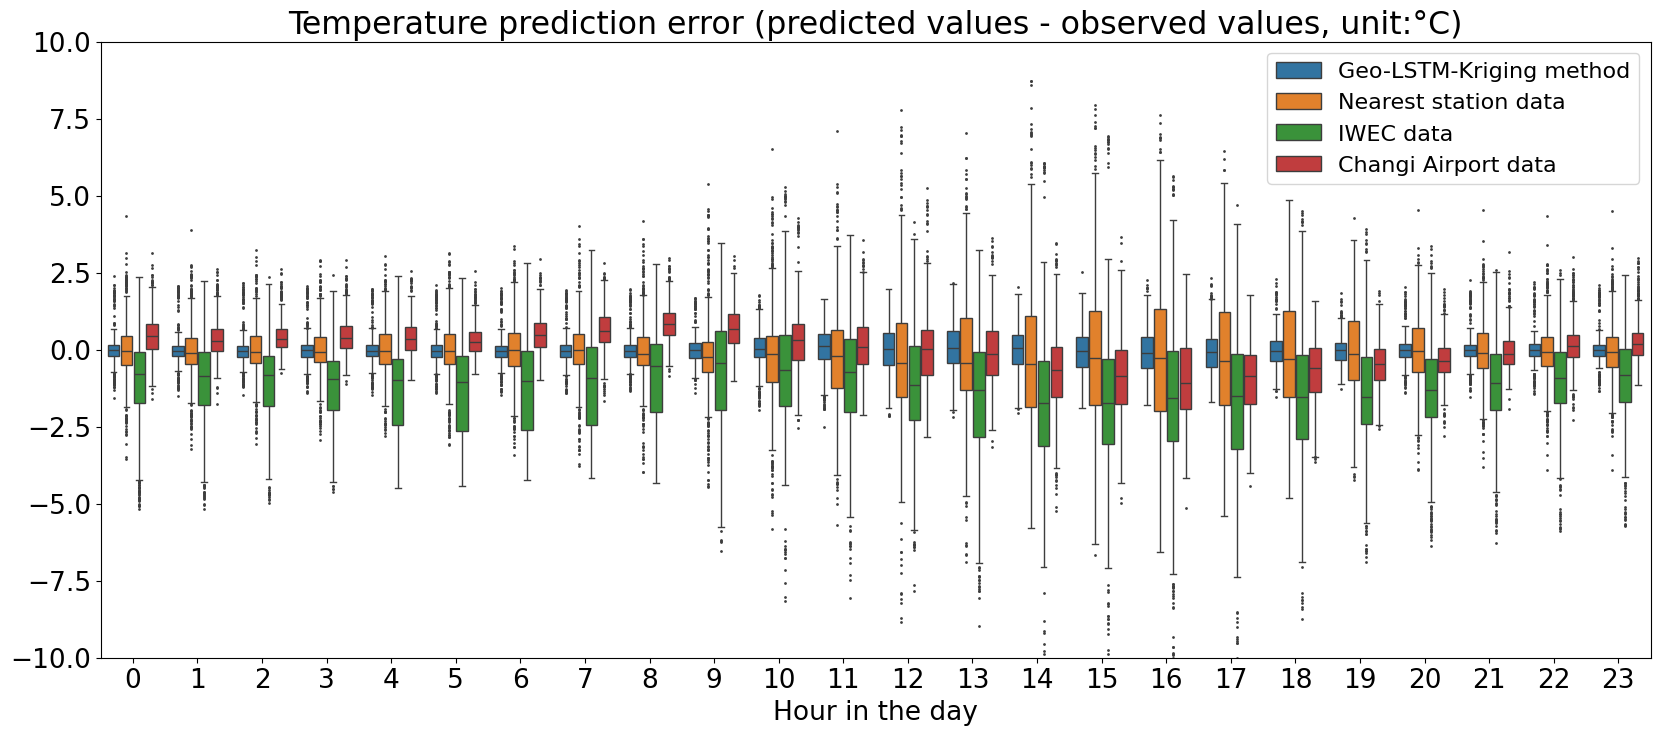

In [765]:
methods=['_lstmrk_','_ne_','_iwec_','_changi_']
measure='Tem0719'
colorpal=sns.color_palette("tab10")
fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True)
ax=axes
methodnames=['Geo-LSTM-Kriging method','Nearest station data','IWEC data','Changi Airport data']
plottempdf=None
for i, method in enumerate(methods):
    tempdf=pd.DataFrame(data=np.array(puredata[measure+method]).reshape(-1,1))
    tempdf['Methods']=methodnames[i]
    tempdf['time']=list(range(16,24))+list(range(24))*419+list(range(16))
    if plottempdf is None:
        plottempdf=tempdf.copy()
    else:
        plottempdf=pd.concat([plottempdf,tempdf])
sns.boxplot(gap=0.1,x='time',y=0,hue='Methods',data = plottempdf, ax=ax,fliersize=1) 
ax.set_ylim(ylim[measure])
ax.set_ylabel('')#"(unit:{})".format(measureunit[measure])) 
ax.set_title("{} prediction error (predicted values - observed values, unit:{})".format(measurenames[measure],measureunit[measure])) 
ax.legend(fontsize=16)
ax.set_xlabel("Hour in the day")


In [67]:
puredata.update(savedata)

In [ ]:
plt.rcParams.update({'font.size': 19})
measure='RH0719'
ylim={'RH0719':[-40,40],'Tem0719':[-10,10]}
#fig, axes = plt.subplots(clusternum, 1, figsize=(10, 16), sharex=True)
methods=['_lstmrk_','_lstmok_','_gruok_','_simplerk_','_simpleok_']#,'_ne_','_iwec_','_changi_'
fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True)
methodnames=['Geo-LSTM-K','LSTM-K','GRU-K','Kriging','IDW','Nearest','IWEC','Changi']
plottempdf=None
ax=axes#[0]
#ax1=axes[1]
for i, method in enumerate(methods):
    tempdf=pd.DataFrame(data=np.array(puredata[measure+method]).reshape(-1,1))#'RH0719'+method]).reshape(-1,1))
    tempdf['Methods']=methodnames[i]
    tempdf['time']=list(range(16,24))+list(range(24))*419+list(range(16))
    #med=np.median(np.array(puredata[measure+method]).reshape(-1,24)*scalingfactor[i],axis=0)
    #ax1.plot(list(np.concatenate([med[16:24],med[0:16]])))
    if plottempdf is None:
        plottempdf=tempdf.copy()
    else:
        plottempdf=pd.concat([plottempdf,tempdf])

bp=sns.boxplot(gap=0.1,x='time',y=0,hue='Methods',data = plottempdf, ax=ax,fliersize=1) 
ax.set_ylim(ylim[measure])
ax.legend(fontsize=16)
ax.set_ylabel('')
ax.set_title("{} prediction error (predicted values - observed values, unit:{}) of different methods".format(measurenames[measure],measureunit[measure])) 
ax.set_xlabel("Hour in the day")

In [ ]:
plt.rcParams.update({'font.size': 19})

for measure in ['RH0719', 'Tem0719']:
    ylim={'RH0719':[-40,40],'Tem0719':[-10,10]}
    #fig, axes = plt.subplots(clusternum, 1, figsize=(10, 16), sharex=True)
    methods=['_lstmrk_','_lstmok_']#,'_ne_','_iwec_','_changi_'
    fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True)
    methodnames=['Geo-LSTM-K','LSTM-K','GRU-K','Kriging','IDW','Nearest','IWEC','Changi']
    plottempdf=None
    ax=axes#[0]
    #ax1=axes[1]
    for i, method in enumerate(methods):
        tempdf=pd.DataFrame(data=np.array(puredata[measure+method]).reshape(-1,1))#'RH0719'+method]).reshape(-1,1))
        tempdf['Methods']=methodnames[i]
        tempdf['time']=list(range(16,24))+list(range(24))*419+list(range(16))
        #med=np.median(np.array(puredata[measure+method]).reshape(-1,24)*scalingfactor[i],axis=0)
        #ax1.plot(list(np.concatenate([med[16:24],med[0:16]])))
        if plottempdf is None:
            plottempdf=tempdf.copy()
        else:
            plottempdf=pd.concat([plottempdf,tempdf])
        stdtmp=np.array(puredata[measure+method])[:,8:-16].reshape(-1,24).std(axis=(0))
        if measure=='RH0719':
            for j in range(len(stdtmp)):
                ax.text(j,8-i*20,'%.2f' % (stdtmp[j]),ha='center',va='bottom',color=colorpal[i],fontsize=11)
                #ax.axvline(4*j+3.5,color='black')
        else:
            for j in range(len(stdtmp)):
                ax.text(j,2-i*4,'%.2f' % (stdtmp[j]),ha='center',va='bottom',color=colorpal[i],fontsize=11)
    #ax.text(0,12,'Blue characters: {} error standard deviation'.format(methodnames[0]),color=colorpal[0],fontsize=16)
    #ax.text(0,11,'Orange characters: {} error standard deviation'.format(methodnames[1]),color=colorpal[1],fontsize=16)
    bp=sns.boxplot(gap=0.1,x='time',y=0,hue='Methods',data = plottempdf, ax=ax,fliersize=1) 
    #ax.set_ylim(ylim[measure])
    ax.legend(fontsize=16)
    ax.set_ylabel('')

    #ax.set_ylabel("(unit:{})".format(measureunit[measure])) 
    ax.set_title("{} prediction error (predicted values - observed values, unit:{}) and error Std Dev".format(measurenames[measure],measureunit[measure])) 
    #ax1.set_title("{} prediction error medians by different methods".format(measurenames[measure]))
    ax.set_xlabel("Hour in the day")
    #leg=plt.legend([tmpt], [methodnames[0]+' std',methodnames[1]+' std'])

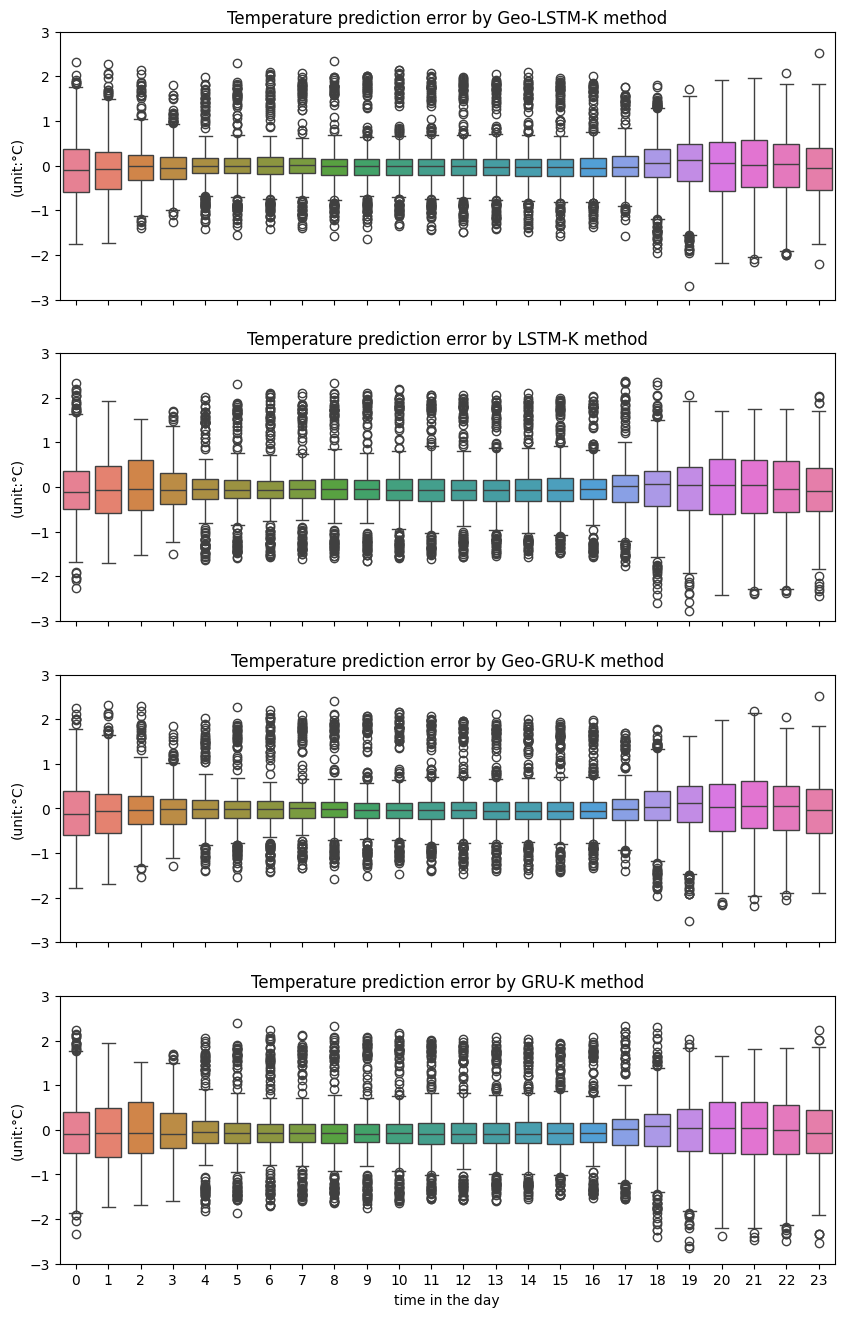

In [39]:
#fig, axes = plt.subplots(clusternum, 1, figsize=(10, 16), sharex=True)
methods=['_grurk_','_gruok_','_lstmrk_','_lstmok_']#,'_ne_','_iwec_','_changi_'
fig, axes = plt.subplots(4, 1, figsize=(10, 16), sharex=True)
methodnames=['Geo-LSTM-K','LSTM-K','Geo-GRU-K','GRU-K','Nearest','IWEC','Changi']
for i, (method,ax) in enumerate(zip(methods,axes)):
#for clusterid,ax in enumerate(axes):
    sns.boxplot(data = puredata[measure+method].reshape(-1,24), ax=ax) 
    #sns.boxplot(data = puredata_[plotdf['cluster']==clusterid].to_numpy().reshape(-1,24), ax=ax) 
    ax.set_ylim([-3,3])
    ax.set_ylabel("(unit:{})".format('°C')) 
    ax.set_title("Temperature prediction error by {} method".format(methodnames[i])) 
    if ax != axes[-1]: 
        ax.set_xlabel('')
    else:
        ax.set_xlabel("time in the day")
        

In [14]:
data=[]
testdata=[]
if batchsize ==1:
    for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
        data.append(Mydata(torch.tensor((np.delete(hourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(hourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
    for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
        testdata.append(Mydata(torch.tensor((np.delete(testhourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(testhourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

else:
    for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
        data.append(Mydata(torch.tensor(np.array([(np.delete(hourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                    ,torch.tensor((np.delete(hourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
    for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
        testdata.append(Mydata(torch.tensor(np.array([(np.delete(testhourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                    ,torch.tensor((np.delete(testhourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))


methods=['_lstmrk_','_lstmok_','_grurk_','_gruok_','_ne_','_iwec_','_changi_']
puredata={}
for method in methods:
    puredata[measure+method]=plotdf.iloc[:,embedding_length:embedding_length+len(data)*batchsize].to_numpy()

In [522]:

#pretrain the nerual network and save in file to speed up the learning
'''
for targetstationid in range(14):
    mymodel = gru(embedding_length=embedding_length,hidden_size=64,output_size=13,batch_size=batchsize)
    with open('trainednw\\{}grumodel_target{}.pkl'.format(measure,targetstationid),'wb') as f:
        pickle.dump(mymodel,f)
    mymodel = MyModel(embedding_length=embedding_length,hidden_size=64,output_size=13,batch_size=batchsize)
    with open('trainednw\\{}lstmmodel_target{}.pkl'.format(measure,targetstationid),'wb') as f:
        pickle.dump(mymodel,f)
'''

In [136]:
#save the prediction errors
'''
savedata=puredata
for key in savedata.keys():
    savedata[key]=np.array(savedata[key]).tolist()
with open(measure+'result.json', 'w') as fp:
    json.dump(savedata, fp)
'''

In [80]:
#load the prediction errors

with open('Tem0719'+'result.json', 'r') as fp:
    savedata1=json.load(fp)
    savedata.update(savedata1)
for key in savedata.keys():
    savedata[key]=np.array(savedata[key],dtype=float)


# Prediction by Geo-LSTM-Kriging

In [15]:

features = ['terrain','distToBuilding','distToTree','distToWalkway','distToRoad','distToPath','distToCourtTrack','distToCarpark']
p = wsdf[features].drop(targetstationid)
target_p = griddf[features]
target_x = np.array(list(zip(griddf.X, griddf.Y)))

feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

#months = ["Feb-19","Mar-19","Apr-19","May-19","Jun-19","Jul-19","Aug-19","Sep-19","Oct-19","Nov-19","Dec-19","Jan-20","Feb-20","Mar-20","Apr-20"]
months = [5,12,31]
#months = [21]
batchindex = 5
### Load base geojson grid to export geojson file
basejson = []
# with open(dir + 'GeoJSON/BaseGrid.geojson', 'r') as file:
#     basejson = json.load(file) 
for i, mth in enumerate(range(len(data))):
    truevalue = hourdata[mth*batchsize+embedding_length:(mth+1)*batchsize+embedding_length,:]
    puredata[measure+'_iwec_'][:,mth*batchsize:(mth+1)*batchsize] = (amydata.iloc[mth*batchsize+embedding_length:(mth+1)*batchsize+embedding_length].to_numpy()-truevalue).transpose()
    puredata[measure+'_changi_'][:,mth*batchsize:(mth+1)*batchsize] = (changidata.iloc[mth*batchsize+embedding_length:(mth+1)*batchsize+embedding_length].to_numpy()-truevalue).transpose()
for targetstationid in range(14):    
    allstations=np.array(range(14))
    otherstationsid=np.delete(allstations,targetstationid).tolist()
    features = ['terrain','distToBuilding','distToTree','distToWalkway','distToRoad','distToPath','distToCourtTrack','distToCarpark']
    p = wsdf[features].drop(targetstationid)
    target_p = wsdf.loc[targetstationid,features].to_numpy().reshape(1,-1)
    target_x = np.array([(wsdf.loc[targetstationid,'X'],wsdf.loc[targetstationid,'Y'])]).reshape(1,-1)

    data=[]
    testdata=[]
    if batchsize ==1:
        for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
            data.append(Mydata(torch.tensor((np.delete(hourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(hourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
        for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
            testdata.append(Mydata(torch.tensor((np.delete(testhourdata[i:i+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32).transpose(0,1),torch.tensor((np.delete(testhourdata[i+embedding_length:i+1+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

    else:
        for i in range(0,hourdata.shape[0]-embedding_length-batchsize,batchsize):
            data.append(Mydata(torch.tensor(np.array([(np.delete(hourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                        ,torch.tensor((np.delete(hourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))
        for i in range(0,testhourdata.shape[0]-embedding_length-batchsize,batchsize):
            testdata.append(Mydata(torch.tensor(np.array([(np.delete(testhourdata[i+k:i+k+embedding_length,:],targetstationid,axis=1)-mean)/std for k in range(batchsize)]),dtype=torch.float32).transpose(1,2)
                        ,torch.tensor((np.delete(testhourdata[i+embedding_length:i+batchsize+embedding_length,:],targetstationid,axis=1)-mean)/std,dtype=torch.float32)))

    with open('trainednw\\{}grumodel_target{}.pkl'.format(measure,targetstationid), 'rb') as f:
        mymodel = pickle.load(f)
    optimizer = torch.optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
    #train_model(mymodel, data, epoch=6000)
    #with open('trainednw\\{}grumodel_target{}.pkl'.format(measure,targetstationid),'wb') as f:
    #    pickle.dump(mymodel,f)
    
    for k in variogram_models:
        # print(k)
        # model = SVR(C=C, gamma=gamma, kernel=k)
        model = RandomForestRegressor( n_estimators=n_estimators, random_state=random_state)
        # model = LinearRegression(copy_X=True, fit_intercept=False)
        x = np.array(list(zip(wsdf.drop(targetstationid).X, wsdf.drop(targetstationid).Y)))
        for i, mth in enumerate(range(0,len(data))):
            for batchindex in range(batchsize):
                
                truevalue = hourdata[mth*batchsize+batchindex+embedding_length,:]
                lastdayvalue = hourdata[mth*batchsize+batchindex+embedding_length-24,:]
                target = mymodel(data[mth].x)[batchindex,:].detach().numpy()*std+mean
                # p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
                #     p, x, target, test_size=0.3, random_state=42
                # )
                print("=" * 40)
                m_ok = OrdinaryKriging(x[:,0],x[:,1],target,variogram_model=k,verbose=False)
                m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

                # m_rk.fit(p_train, x_train,target_train)
                # score = m_rk.score(p_test, x_test,target_test)
                # scores_mths.append(score)

                m_rk.fit(p.values, x, target)
                result = m_rk.predict(target_p, target_x)
                puredata[measure+'_grurk_'][targetstationid,mth*batchsize+batchindex] = result[0]-truevalue[targetstationid]
                z,sigma=m_ok.execute('points',target_x[0,0],target_x[0,1])
                puredata[measure+'_gruok_'][targetstationid,mth*batchsize+batchindex] = z[0]-truevalue[targetstationid]
                puredata[measure+'_ne_'][targetstationid,mth*batchsize+batchindex] = lastdayvalue[otherstationsid[np.argmin((wsdf.loc[otherstationsid,'X']-wsdf.loc[targetstationid,'X'])**2+(wsdf.loc[otherstationsid,'Y']-wsdf.loc[targetstationid,'Y'])**2)]]-truevalue[targetstationid]
                
    with open('trainednw\\{}lstmmodel_target{}.pkl'.format(measure,targetstationid), 'rb') as f:
        mymodel = pickle.load(f)
    optimizer = torch.optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
    #train_model(mymodel, data, epoch=6000)
    with open('trainednw\\{}lstmmodel_target{}.pkl'.format(measure,targetstationid),'wb') as f:
        pickle.dump(mymodel,f)
    for k in variogram_models:
        model = RandomForestRegressor( n_estimators=n_estimators, random_state=random_state)
        x = np.array(list(zip(wsdf.drop(targetstationid).X, wsdf.drop(targetstationid).Y)))
        for i, mth in enumerate(range(0,len(data))):
            for batchindex in range(batchsize):
                truevalue = hourdata[mth*batchsize+batchindex+embedding_length,:]
                target = mymodel(data[mth].x)[batchindex,:].detach().numpy()*std+mean
                print("=" * 40)
                m_ok = OrdinaryKriging(x[:,0],x[:,1],target,variogram_model=k,verbose=False)
                m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)
                m_rk.fit(p.values, x, target)
                result = m_rk.predict(target_p, target_x)
                puredata[measure+'_lstmrk_'][targetstationid,mth*batchsize+batchindex] = result[0]-truevalue[targetstationid]
                z,sigma=m_ok.execute('points',target_x[0,0],target_x[0,1])
                puredata[measure+'_lstmok_'][targetstationid,mth*batchsize+batchindex] = z[0]-truevalue[targetstationid]

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished

In [83]:
mymodel(data[mth].x)[batchindex,:].detach().numpy()*std+mean

'RH0719'

In [84]:

features = ['terrain','distToBuilding','distToTree','distToWalkway','distToRoad','distToPath','distToCourtTrack','distToCarpark']
feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

#months = ["Feb-19","Mar-19","Apr-19","May-19","Jun-19","Jul-19","Aug-19","Sep-19","Oct-19","Nov-19","Dec-19","Jan-20","Feb-20","Mar-20","Apr-20"]
months = [5,12,31]
#months = [21]
batchindex = 5
### Load base geojson grid to export geojson file
basejson = []
# with open(dir + 'GeoJSON/BaseGrid.geojson', 'r') as file:
#     basejson = json.load(file) 
#for i, mth in enumerate(range(len(data))):
#    truevalue = hourdata[mth*batchsize+embedding_length:(mth+1)*batchsize+embedding_length,:]
#    puredata[measure+'_iwec_'][:,mth*batchsize:(mth+1)*batchsize] = (amydata.iloc[mth*batchsize+embedding_length:(mth+1)*batchsize+embedding_length].to_numpy()-truevalue).transpose()
#    puredata[measure+'_changi_'][:,mth*batchsize:(mth+1)*batchsize] = (changidata.iloc[mth*batchsize+embedding_length:(mth+1)*batchsize+embedding_length].to_numpy()-truevalue).transpose()

puredata[measure+'_simplerk_']=plotdf.iloc[:,embedding_length:embedding_length+len(data)*batchsize].to_numpy()
puredata[measure+'_simpleok_']=plotdf.iloc[:,embedding_length:embedding_length+len(data)*batchsize].to_numpy()    
for targetstationid in range(14):    
    allstations=np.array(range(14))
    otherstationsid=np.delete(allstations,targetstationid).tolist()
    features = ['terrain','distToBuilding','distToTree','distToWalkway','distToRoad','distToPath','distToCourtTrack','distToCarpark']
    p = wsdf[features].drop(targetstationid)
    target_p = wsdf.loc[targetstationid,features].to_numpy().reshape(1,-1)
    target_x = np.array([(wsdf.loc[targetstationid,'X'],wsdf.loc[targetstationid,'Y'])]).reshape(1,-1)

    for k in variogram_models:
        # print(k)
        # model = SVR(C=C, gamma=gamma, kernel=k)
        model = RandomForestRegressor( n_estimators=n_estimators, random_state=random_state)
        # model = LinearRegression(copy_X=True, fit_intercept=False)
        x = np.array(list(zip(wsdf.drop(targetstationid).X, wsdf.drop(targetstationid).Y)))
        for i, mth in enumerate(range(0,len(data))):
            for batchindex in range(batchsize):
                
                truevalue = hourdata[mth*batchsize+batchindex+embedding_length,:]
                lastdayvalue = hourdata[mth*batchsize+batchindex+embedding_length-24,:]
                target = lastdayvalue[otherstationsid]
                #target = mymodel(data[mth].x)[batchindex,:].detach().numpy()*std+mean
                # p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
                #     p, x, target, test_size=0.3, random_state=42
                # )
                print("=" * 40)
                m_ok = OrdinaryKriging(x[:,0],x[:,1],target,variogram_model=k,verbose=False)
                m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

                # m_rk.fit(p_train, x_train,target_train)
                # score = m_rk.score(p_test, x_test,target_test)
                # scores_mths.append(score)

                m_rk.fit(p.values, x, target)
                result = m_rk.predict(target_p, target_x)
                puredata[measure+'_simplerk_'][targetstationid,mth*batchsize+batchindex] = result[0]-truevalue[targetstationid]
                z,sigma=m_ok.execute('points',target_x[0,0],target_x[0,1])
                puredata[measure+'_simpleok_'][targetstationid,mth*batchsize+batchindex] = z[0]-truevalue[targetstationid]
                #puredata[measure+'_ne_'][targetstationid,mth*batchsize+batchindex] = lastdayvalue[otherstationsid[np.argmin((wsdf.loc[otherstationsid,'X']-wsdf.loc[targetstationid,'X'])**2+(wsdf.loc[otherstationsid,'Y']-wsdf.loc[targetstationid,'Y'])**2)]]-truevalue[targetstationid]
            

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished

In [122]:
puredata.keys()

dict_keys(['Tem0719_lstmrk_', 'Tem0719_lstmok_', 'Tem0719_grurk_', 'Tem0719_gruok_', 'Tem0719_ne_', 'Tem0719_iwec_', 'Tem0719_changi_'])

In [ ]:
for i, mth in enumerate(range(len(data))):
        
        truevalue = hourdata[mth*batchsize+embedding_length:mth*batchsize+embedding_length+batchsize,:]
        target = mymodel(data[mth].x).detach().numpy()*std+mean
        # p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
        #     p, x, target, test_size=0.3, random_state=42
        # )
        print("=" * 40)
        m_ok = OrdinaryKriging(x[:,0],x[:,1],target,variogram_model=k,verbose=False)
        m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

        # m_rk.fit(p_train, x_train,target_train)
        # score = m_rk.score(p_test, x_test,target_test)
        # scores_mths.append(score)

        m_rk.fit(p.values, x, target)
        result = m_rk.predict(target_p, target_x)
        puredata[measure+'_grurk_'][targetstationid,mth*batchsize+batchindex] = result[0]-truevalue[targetstationid]
        z,sigma=m_ok.execute('points',target_x[0,0],target_x[0,1])
        puredata[measure+'_gruok_'][targetstationid,mth*batchsize+batchindex] = z[0]-truevalue[targetstationid]